In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
from PIL import Image
import io
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 设置随机种子，确保实验可复现
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def extract_modality(text):
    """从文本中提取modality信息"""
    if not isinstance(text, str):
        return None

    text = text.lower()

    modality_patterns = {
        'mri': r'\b(mri|magnetic resonance( imaging)?|mr imaging|nmr|magnetic resonance imaging)\b',
        'ct': r'\b(ct scan|ct|computed tomography|cat scan|computerized tomography|computed axial tomography)\b',
        'xray': r'\b(x-ray|xray|radiograph|radiography|chest x|cxr|roentgen|radiogram|plain film)\b'
    }

    for modality, pattern in modality_patterns.items():
        if re.search(pattern, text):
            return modality
    return None

def load_rad_data(train_path, test_path):
    """加载并合并RAD数据集"""
    print("\n=== Loading RAD Dataset ===")

    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)

    print(f"Train set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")

    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    print(f"Combined dataset size: {len(combined_df)}")

    print("\n=== Text Analysis ===")
    question_lengths = combined_df['question'].str.len().describe()
    answer_lengths = combined_df['answer'].str.len().describe()

    print("\nQuestion length statistics:")
    print(question_lengths)
    print("\nAnswer length statistics:")
    print(answer_lengths)

    print("\n=== Data Quality Check ===")
    null_counts = combined_df.isnull().sum()
    print("\nNull values in each column:")
    print(null_counts)

    print("\n=== Initial Modality Analysis ===")
    question_modalities = combined_df['question'].apply(extract_modality)
    answer_modalities = combined_df['answer'].apply(extract_modality)

    combined_modalities = question_modalities.combine_first(answer_modalities)
    modality_counts = combined_modalities.value_counts()

    print("\nModality distribution in text:")
    print(modality_counts)
    print("\nPercentage of samples with modality information:")
    print(f"{(len(combined_modalities.dropna()) / len(combined_df)) * 100:.2f}%")

    return combined_df

In [ ]:
# 模型架构部分
class MedicalModalityAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # 解剖结构感知的空间注意力
        self.anatomy_attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//2, kernel_size=7, padding=3),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(),
            nn.Conv2d(in_channels//2, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # 模态特定的纹理注意力
        self.texture_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels//16, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels//16, in_channels, 1),
            nn.Sigmoid()
        )

        # 多尺度特征聚合
        self.multi_scale = nn.ModuleList([
            nn.Conv2d(in_channels, in_channels//4, 3, padding=1, dilation=1),
            nn.Conv2d(in_channels, in_channels//4, 3, padding=2, dilation=2),
            nn.Conv2d(in_channels, in_channels//4, 3, padding=4, dilation=4)
        ])

        self.channel_adjust = nn.Conv2d(in_channels//4*3, in_channels, 1)

    def forward(self, x):
        anatomy_weight = self.anatomy_attention(x)
        texture_weight = self.texture_attention(x)

        multi_scale_features = []
        for conv in self.multi_scale:
            multi_scale_features.append(conv(x))
        multi_scale_feat = torch.cat(multi_scale_features, dim=1)
        multi_scale_feat = self.channel_adjust(multi_scale_feat)

        enhanced = x * anatomy_weight * texture_weight
        return enhanced + multi_scale_feat

class ModalityClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        self.attention1 = MedicalModalityAttention(256)
        self.attention2 = MedicalModalityAttention(512)
        self.attention3 = MedicalModalityAttention(1024)
        self.attention4 = MedicalModalityAttention(2048)

        in_features = self.backbone.fc.in_features
        self.modality_head = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.attention1(self.backbone.layer1(x))
        x = self.attention2(self.backbone.layer2(x))
        x = self.attention3(self.backbone.layer3(x))
        x = self.attention4(self.backbone.layer4(x))

        x = self.backbone.avgpool(x)
        features = torch.flatten(x, 1)

        return self.modality_head(features)

# 数据增强和数据集类
class MedicalImageAugmentation:
    def __init__(self):
        # 基础增强
        self.base_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1)
            ),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        # MRI特定增强
        self.mri_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),  # 更大角度
            transforms.RandomAffine(
                degrees=0,
                translate=(0.15, 0.15),  # 更大平移
                scale=(0.85, 1.15)      # 更大缩放
            ),
            transforms.ColorJitter(
                brightness=0.3,
                contrast=0.3,   # 更强对比度
                saturation=0.2,
                hue=0.1
            ),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        # 测试时的转换
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

In [ ]:
class RADDataset(Dataset):
    def __init__(self, df, is_labeled=True, mode='train'):
        self.df = df
        self.is_labeled = is_labeled
        self.mode = mode
        self.augmentation = MedicalImageAugmentation()

        self.valid_samples = []
        self.unlabeled_samples = []

        self.modality_to_idx = {
            'mri': 0,
            'ct': 1,
            'xray': 2
        }

        print("\n=== Dataset Statistics ===")
        total_samples = len(df)
        valid_count = 0
        modality_counts = {'mri': 0, 'ct': 0, 'xray': 0}

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            question_modality = extract_modality(row['question'])
            answer_modality = extract_modality(row['answer'])

            modality = question_modality or answer_modality

            if modality in ['mri', 'ct', 'xray']:
                self.valid_samples.append({
                    'image': row['image'],
                    'modality': modality,
                    'index': idx
                })
                modality_counts[modality] += 1
                valid_count += 1
            else:
                self.unlabeled_samples.append({
                    'image': row['image'],
                    'index': idx
                })

        if self.is_labeled:
            print(f"\nTotal samples: {total_samples}")
            print(f"Labeled samples: {valid_count} ({valid_count/total_samples*100:.2f}%)")
            print(f"Unlabeled samples: {total_samples - valid_count} ({(total_samples-valid_count)/total_samples*100:.2f}%)")

            print("\n=== Class Distribution ===")
            for modality, count in modality_counts.items():
                print(f"{modality.upper()}: {count} samples ({count/valid_count*100:.2f}%)")

    def decode_image(self, image_data):
        try:
            if isinstance(image_data, dict):
                if 'bytes' in image_data:
                    bytes_data = image_data['bytes']
                    if isinstance(bytes_data, str):
                        bytes_data = bytes_data.encode('latin1')
                    img = Image.open(io.BytesIO(bytes_data))
                    return np.array(img)
                elif 'array' in image_data:
                    return np.array(image_data['array'])
            return np.array(image_data)
        except Exception as e:
            print(f"\nError decoding image:")
            print(f"Image data type: {type(image_data)}")
            if isinstance(image_data, dict):
                print(f"Dict keys: {image_data.keys()}")
            print(f"Error: {str(e)}")
            raise

    def __len__(self):
        if self.is_labeled:
            return len(self.valid_samples)
        return len(self.unlabeled_samples)

    def __getitem__(self, idx):
        if self.is_labeled:
            sample = self.valid_samples[idx]
            image_data = sample['image']
            label = self.modality_to_idx[sample['modality']]

            # 根据模态选择增强策略
            if self.mode == 'train':
                if sample['modality'] == 'mri':
                    image_tensor = self._process_image(image_data, aug_type='mri')
                else:
                    image_tensor = self._process_image(image_data, aug_type='base')
            else:
                image_tensor = self._process_image(image_data, aug_type='test')

            return image_tensor, label
        else:
            sample = self.unlabeled_samples[idx]
            image_data = sample['image']

            weak_aug = self._process_image(image_data, aug_type='base')
            strong_aug = self._process_image(image_data, aug_type='mri')

            return weak_aug, strong_aug

    def _process_image(self, image_data, aug_type='base'):
        try:
            image_array = self.decode_image(image_data)

            if len(image_array.shape) == 2:
                image_array = np.stack([image_array] * 3, axis=-1)
            elif len(image_array.shape) == 3 and image_array.shape[2] == 4:
                image_array = image_array[:, :, :3]

            image = Image.fromarray(image_array.astype('uint8'))

            if aug_type == 'mri':
                return self.augmentation.mri_aug(image)
            elif aug_type == 'test':
                return self.augmentation.test_transform(image)
            else:
                return self.augmentation.base_aug(image)

        except Exception as e:
            print(f"\nError processing image:")
            print(f"Error: {str(e)}")
            raise

In [ ]:
# 训练和评估函数
def train_epoch(model, train_loader, unlabeled_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    unlabeled_iter = iter(unlabeled_loader)

    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (inputs, labels) in enumerate(pbar):
        inputs = inputs.to(device)
        labels = labels.to(device)

        try:
            unlabeled_weak, unlabeled_strong = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            unlabeled_weak, unlabeled_strong = next(unlabeled_iter)

        unlabeled_weak = unlabeled_weak.to(device)
        unlabeled_strong = unlabeled_strong.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        with torch.no_grad():
            pseudo_outputs = model(unlabeled_weak)
            pseudo_probs = F.softmax(pseudo_outputs, dim=1)
            max_probs, pseudo_labels = torch.max(pseudo_probs, dim=1)
            mask = max_probs.ge(0.95)

        strong_outputs = model(unlabeled_strong)

        sup_loss = criterion(outputs, labels)
        unsup_loss = (F.cross_entropy(strong_outputs, pseudo_labels,
                                    reduction='none') * mask).mean()

        loss = sup_loss + 0.5 * unsup_loss

        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        total_loss += loss.item()

        pbar.set_postfix({
            'Loss': f'{total_loss/(batch_idx+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    return total_loss / len(train_loader), correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            total_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    classification_metrics = classification_report(
        all_labels,
        all_preds,
        target_names=['mri', 'ct', 'xray'],
        output_dict=True
    )

    return (total_loss / len(test_loader),
            correct / total,
            classification_metrics,
            all_preds,
            all_labels)

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_title('Accuracy History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['MRI', 'CT', 'X-ray'],
                yticklabels=['MRI', 'CT', 'X-ray'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Using device: cuda

Loading RAD dataset...

=== Dataset Statistics ===


100%|██████████| 2244/2244 [00:00<00:00, 18601.19it/s]



Total samples: 2244
Labeled samples: 156 (6.95%)
Unlabeled samples: 2088 (93.05%)

=== Class Distribution ===
MRI: 57 samples (36.54%)
CT: 44 samples (28.21%)
XRAY: 55 samples (35.26%)

=== Dataset Statistics ===


100%|██████████| 2244/2244 [00:00<00:00, 18851.86it/s]



=== Dataset Statistics ===


100%|██████████| 2244/2244 [00:00<00:00, 18977.49it/s]



Total samples: 2244
Labeled samples: 156 (6.95%)
Unlabeled samples: 2088 (93.05%)

=== Class Distribution ===
MRI: 57 samples (36.54%)
CT: 44 samples (28.21%)
XRAY: 55 samples (35.26%)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


No pretrained model found, starting from scratch

Starting training...

Epoch 1/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]



Training Loss: 0.9778, Accuracy: 0.3871
Validation Loss: 1.3207, Accuracy: 0.5000

Detailed metrics for each modality:
mri:
  Precision: 0.4167
  Recall: 0.9091
  F1-score: 0.5714
ct:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571

Saving new best model with validation accuracy: 0.5000


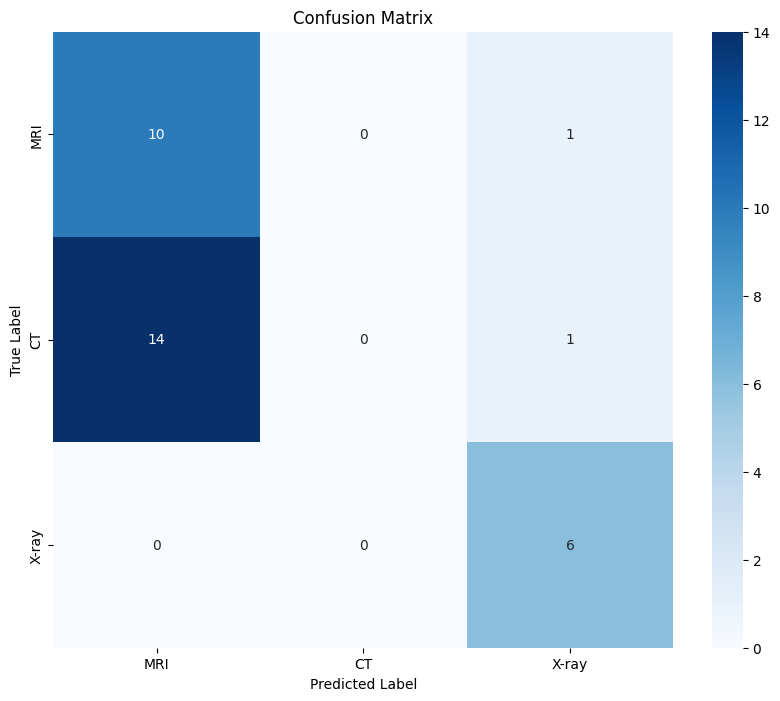


Epoch 2/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]



Training Loss: 0.8309, Accuracy: 0.6613
Validation Loss: 0.7244, Accuracy: 0.5000

Detailed metrics for each modality:
mri:
  Precision: 0.4167
  Recall: 0.9091
  F1-score: 0.5714
ct:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571


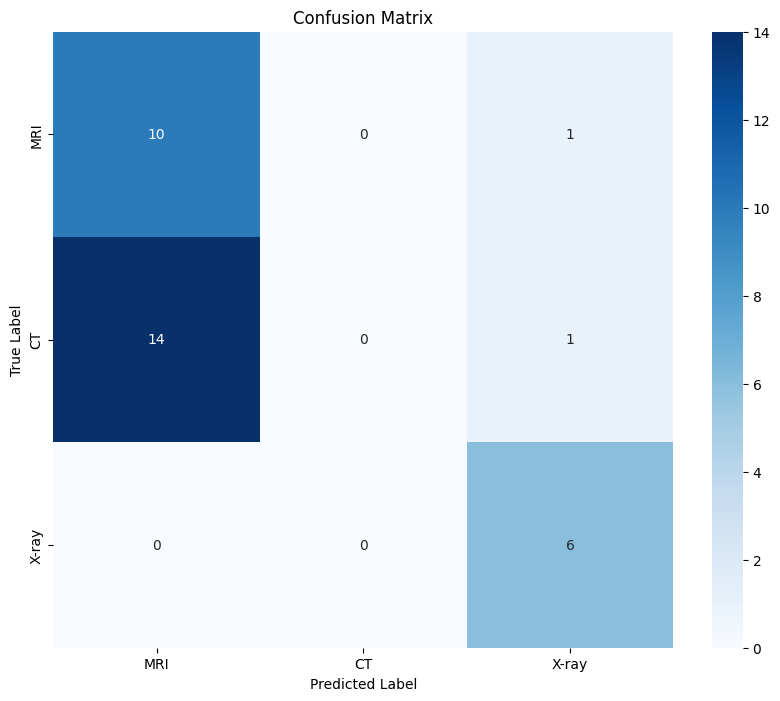


Epoch 3/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]



Training Loss: 0.7433, Accuracy: 0.7016
Validation Loss: 0.7051, Accuracy: 0.8750

Detailed metrics for each modality:
mri:
  Precision: 0.9000
  Recall: 0.8182
  F1-score: 0.8571
ct:
  Precision: 0.9286
  Recall: 0.8667
  F1-score: 0.8966
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571

Saving new best model with validation accuracy: 0.8750


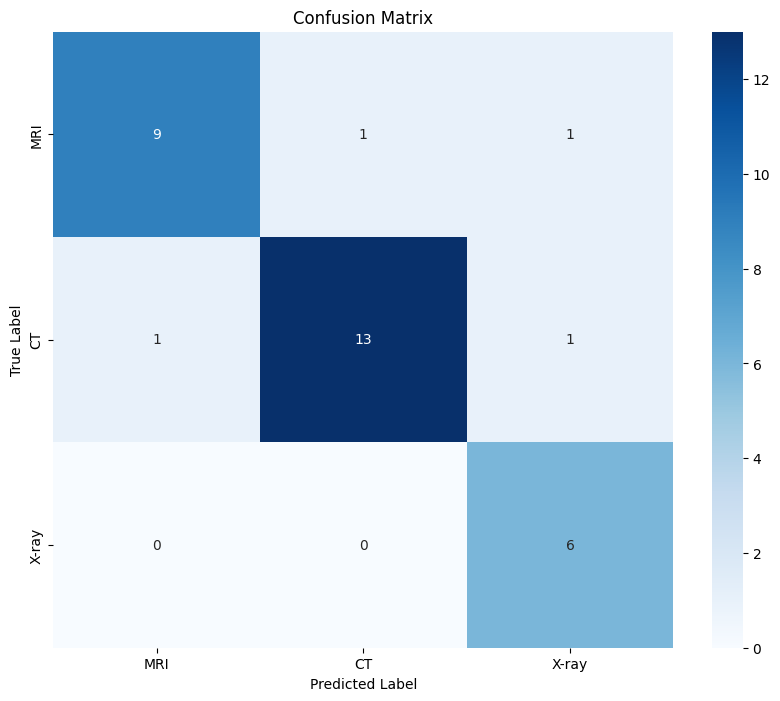


Epoch 4/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]



Training Loss: 0.6118, Accuracy: 0.7984
Validation Loss: 0.6716, Accuracy: 0.6875

Detailed metrics for each modality:
mri:
  Precision: 0.5625
  Recall: 0.8182
  F1-score: 0.6667
ct:
  Precision: 0.8750
  Recall: 0.4667
  F1-score: 0.6087
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571


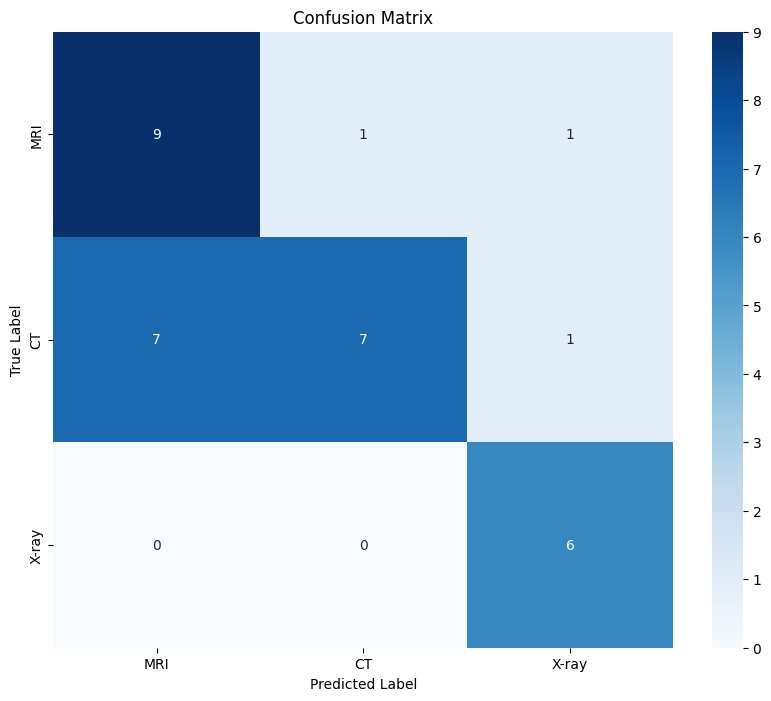


Epoch 5/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]



Training Loss: 0.5497, Accuracy: 0.8145
Validation Loss: 0.7249, Accuracy: 0.5000

Detailed metrics for each modality:
mri:
  Precision: 0.4167
  Recall: 0.9091
  F1-score: 0.5714
ct:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571


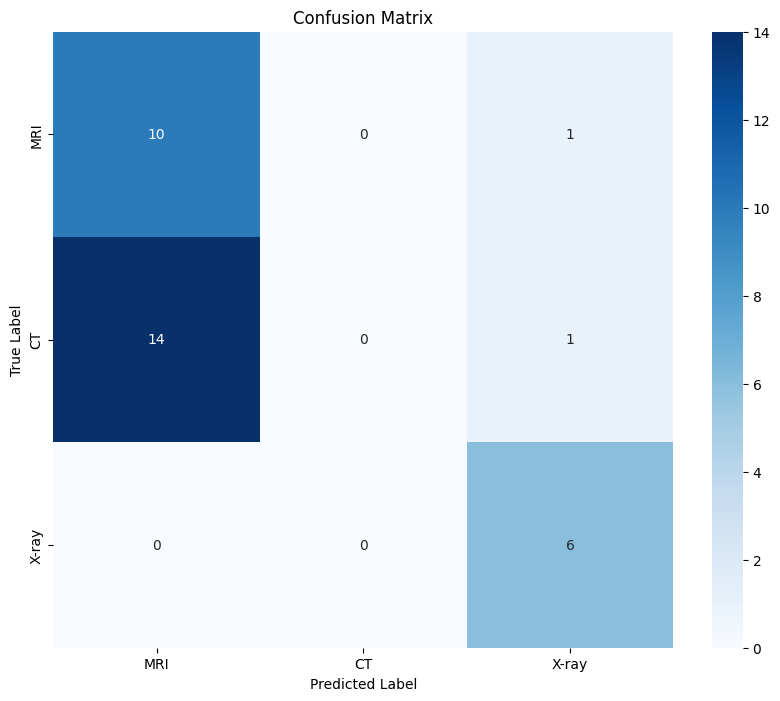


Epoch 6/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]



Training Loss: 0.5357, Accuracy: 0.8065
Validation Loss: 0.5649, Accuracy: 0.7812

Detailed metrics for each modality:
mri:
  Precision: 0.7500
  Recall: 0.8182
  F1-score: 0.7826
ct:
  Precision: 0.9091
  Recall: 0.6667
  F1-score: 0.7692
xray:
  Precision: 0.6667
  Recall: 1.0000
  F1-score: 0.8000


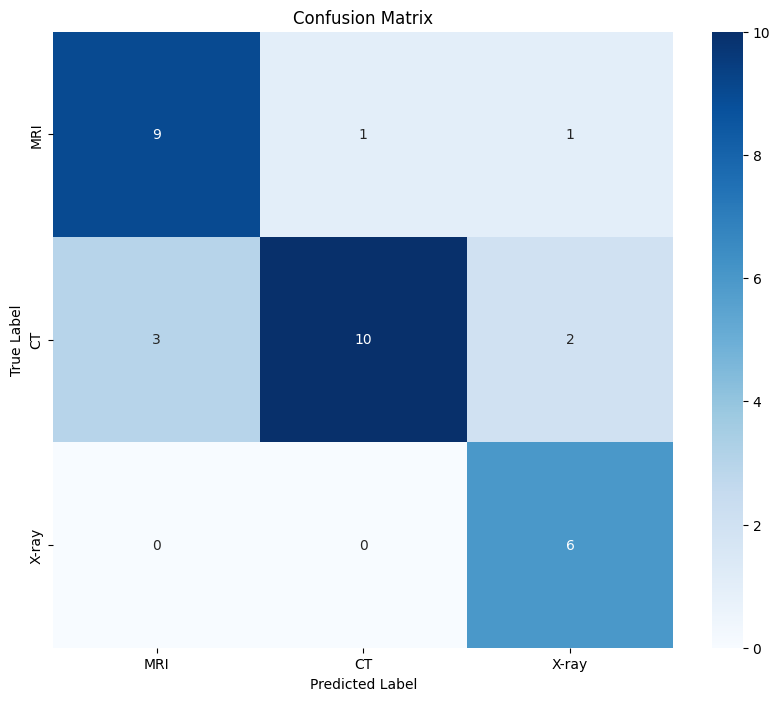


Epoch 7/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]



Training Loss: 0.4477, Accuracy: 0.8145
Validation Loss: 0.5128, Accuracy: 0.8438

Detailed metrics for each modality:
mri:
  Precision: 0.8182
  Recall: 0.8182
  F1-score: 0.8182
ct:
  Precision: 0.9231
  Recall: 0.8000
  F1-score: 0.8571
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571


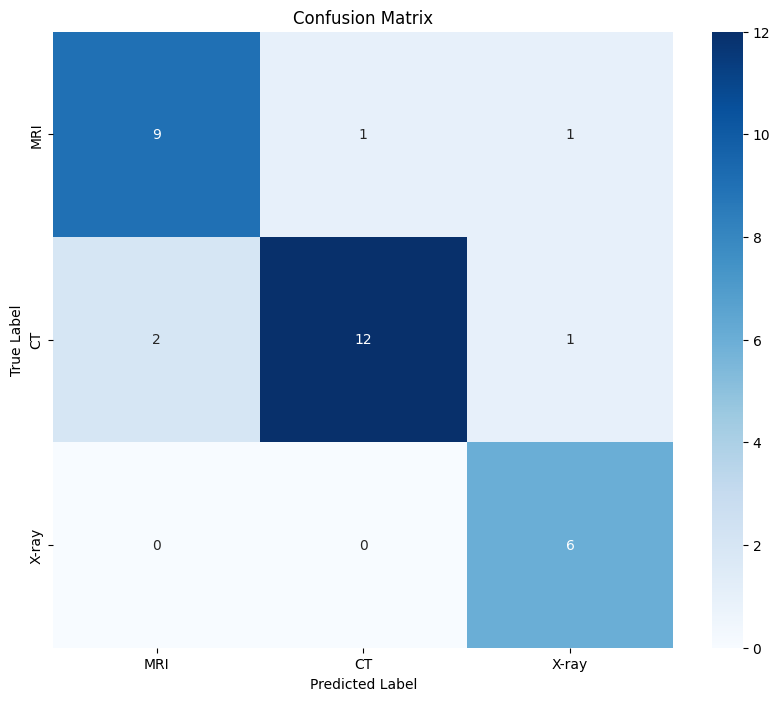


Epoch 8/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]



Training Loss: 0.4202, Accuracy: 0.8548
Validation Loss: 0.4222, Accuracy: 0.9062

Detailed metrics for each modality:
mri:
  Precision: 1.0000
  Recall: 0.8182
  F1-score: 0.9000
ct:
  Precision: 0.9333
  Recall: 0.9333
  F1-score: 0.9333
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571

Saving new best model with validation accuracy: 0.9062


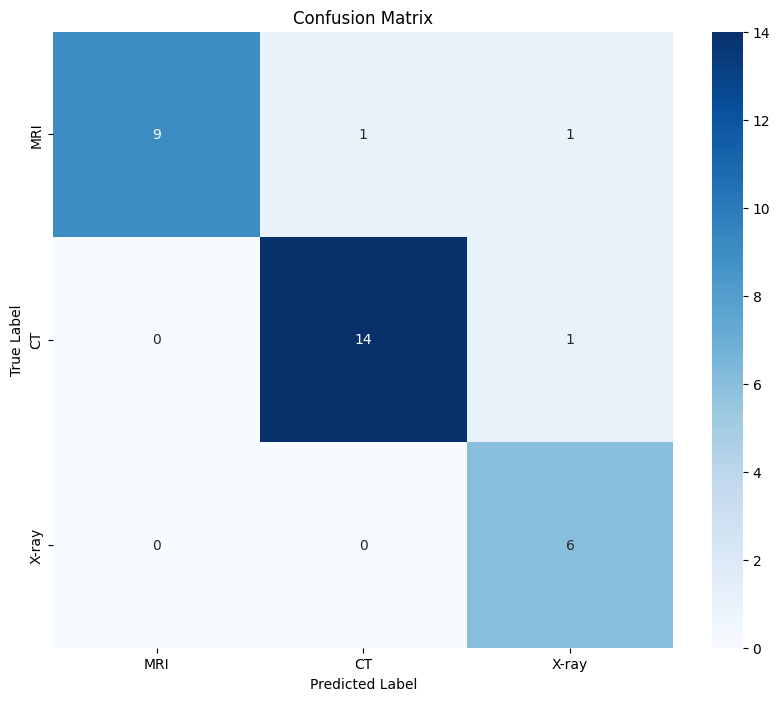


Epoch 9/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]



Training Loss: 0.5073, Accuracy: 0.9032
Validation Loss: 0.4489, Accuracy: 0.8438

Detailed metrics for each modality:
mri:
  Precision: 0.8889
  Recall: 0.7273
  F1-score: 0.8000
ct:
  Precision: 0.8667
  Recall: 0.8667
  F1-score: 0.8667
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571


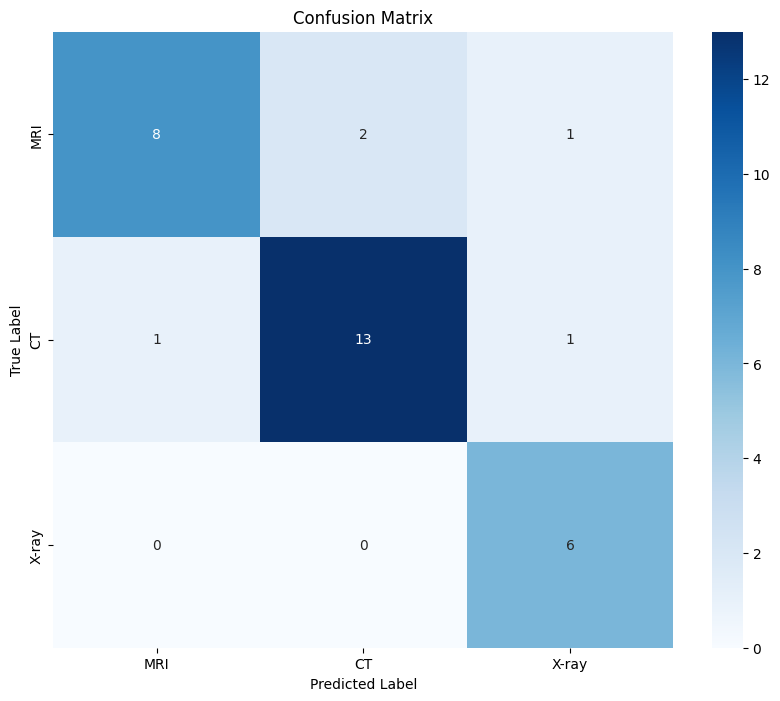


Epoch 10/10


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]



Training Loss: 0.4352, Accuracy: 0.8952
Validation Loss: 0.4447, Accuracy: 0.8438

Detailed metrics for each modality:
mri:
  Precision: 0.8182
  Recall: 0.8182
  F1-score: 0.8182
ct:
  Precision: 0.9231
  Recall: 0.8000
  F1-score: 0.8571
xray:
  Precision: 0.7500
  Recall: 1.0000
  F1-score: 0.8571


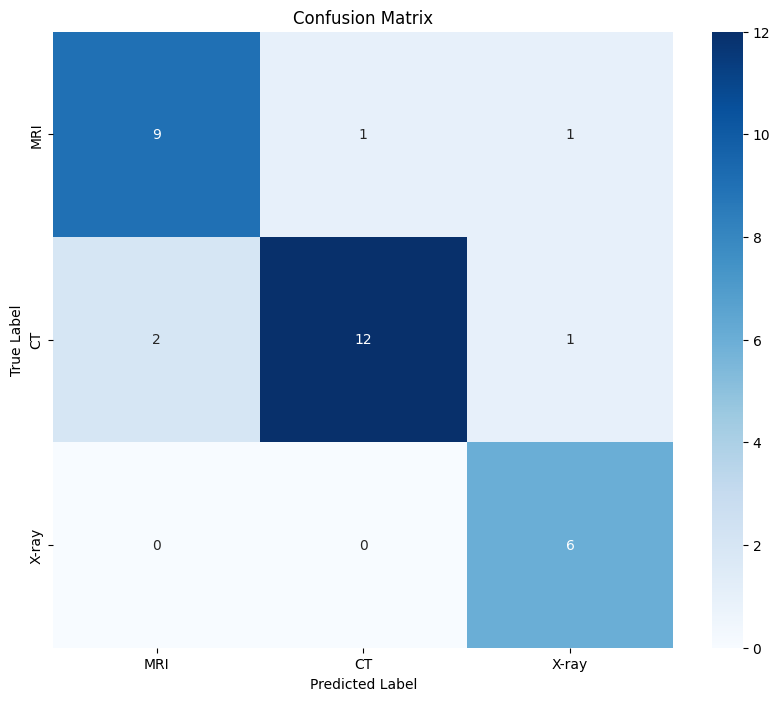

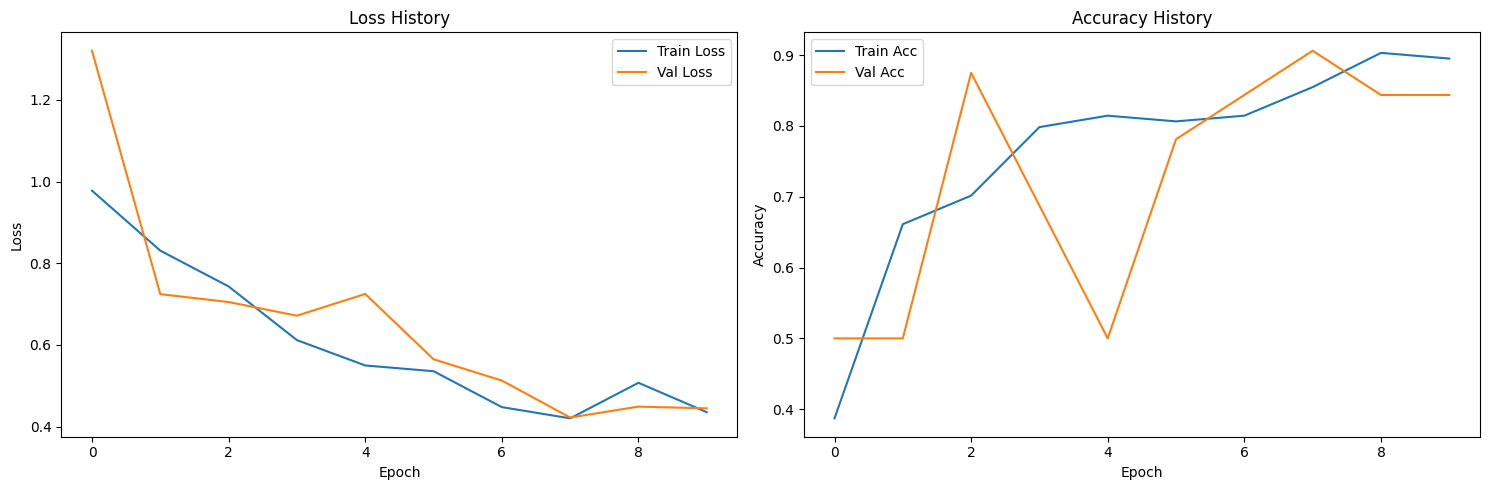


Training completed!
Best validation accuracy: 0.9062


In [ ]:
def finetune_model():
    set_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("\nLoading RAD dataset...")
    train_path = '/content/drive/MyDrive/PhD/Research1/RADdataset/train-00000-of-00001-eb8844602202be60.parquet'
    test_path = '/content/drive/MyDrive/PhD/Research1/RADdataset/test-00000-of-00001-e5bc3d208bb4deeb.parquet'
    rad_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)
    combined_df = pd.concat([rad_df, test_df], ignore_index=True)

    # 创建有标签和无标签数据集
    labeled_dataset = RADDataset(combined_df, is_labeled=True, mode='train')
    unlabeled_dataset = RADDataset(combined_df, is_labeled=False)
    test_dataset = RADDataset(combined_df, is_labeled=True, mode='test')

    # 划分训练集和验证集
    total_size = len(labeled_dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])

    # 创建数据加载器
    batch_size = 8
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    unlabeled_loader = DataLoader(
        unlabeled_dataset,
        batch_size=batch_size*2,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # 初始化模型
    model = ModalityClassifier(num_classes=3)
    model_path = '/content/drive/MyDrive/PhD/Research1/modelparasave/slake_modality_model_improved.pth'

    if os.path.exists(model_path):
        print(f"Loading pretrained model from {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Pretrained model loaded successfully")
    else:
        print("No pretrained model found, starting from scratch")

    model = model.to(device)

    # 设置损失函数（带权重）
    class_weights = torch.FloatTensor([1.5, 1.0, 1.0]).to(device)  # MRI权重更高
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 设置优化器
    optimizer = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': 1e-5},
        {'params': model.attention1.parameters(), 'lr': 1e-4},
        {'params': model.attention2.parameters(), 'lr': 1e-4},
        {'params': model.attention3.parameters(), 'lr': 1e-4},
        {'params': model.attention4.parameters(), 'lr': 1e-4},
        {'params': model.modality_head.parameters(), 'lr': 1e-4}
    ], weight_decay=0.01)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    # 训练历史记录
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'modality_metrics': []
    }

    # 开始训练
    num_epochs = 10
    best_acc = 0
    print("\nStarting training...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # 训练阶段
        train_loss, train_acc = train_epoch(
            model, train_loader, unlabeled_loader, criterion, optimizer, device
        )

        # 验证阶段
        val_loss, val_acc, metrics, val_preds, val_labels = evaluate(
            model, val_loader, criterion, device
        )

        scheduler.step()

        # 更新历史记录
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['modality_metrics'].append(metrics)

        # 打印当前epoch的详细信息
        print(f"\nTraining Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        print("\nDetailed metrics for each modality:")
        for modality in ['mri', 'ct', 'xray']:
            print(f"{modality}:")
            print(f"  Precision: {metrics[modality]['precision']:.4f}")
            print(f"  Recall: {metrics[modality]['recall']:.4f}")
            print(f"  F1-score: {metrics[modality]['f1-score']:.4f}")

        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            print(f"\nSaving new best model with validation accuracy: {best_acc:.4f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'history': history
            }, model_path)

        # 每个epoch结束后绘制混淆矩阵
        plot_confusion_matrix(val_labels, val_preds)

    # 训练结束后绘制训练历史
    plot_training_history(history)

    print("\nTraining completed!")
    print(f"Best validation accuracy: {best_acc:.4f}")

if __name__ == "__main__":
    finetune_model()

In [ ]:
#=============================rad数据集分析========================================

Loading RAD dataset...
Loading RAD dataset...

=== Analyzing Anatomy Patterns in Dataset ===


Analyzing text: 100%|██████████| 2244/2244 [00:00<00:00, 21320.50it/s]


=== Word Frequency Analysis ===

Top 30 terms in questions:
the: 1736
is: 1518
what: 575
this: 571
in: 530
of: 436
there: 432
image: 426
are: 324
a: 274
mass: 154
where: 149
lesion: 148
present: 139
located: 125
or: 118
which: 108
patient: 107
does: 104
on: 103
left: 94
normal: 93
you: 92
seen: 91
contrast: 88
right: 85
to: 82
how: 80
brain: 78
was: 74

Top 30 terms in answers:
no: 606
yes: 585
right: 146
the: 110
left: 86
lobe: 57
and: 55
axial: 45
of: 41
in: 25
x: 23
with: 23
mri: 21
contrast: 21
lateral: 21
lung: 20
bilateral: 18
pa: 18
ct: 18
cerebellum: 17
is: 17
flair: 16
ray: 16
t2: 16
weighted: 16
occipital: 16
brain: 16
lesion: 16
frontal: 15
pleural: 15

=== Medical Term Analysis ===

Medical terms found in questions:
brain: 78
head: 4
skull: 18
chest: 20
thorax: 6
lung: 73
heart: 58
abdomen: 8
liver: 52
kidney: 32
spine: 2
neck: 1
pelvis: 4
bone: 5
joint: 1

Medical terms found in answers:
brain: 16
head: 4
skull: 1
chest: 12
thorax: 2
lung: 20
heart: 4
abdomen: 6
liver: 7



Common anatomy term co-occurrences:
('lung',): 112
('brain',): 99
('kidney',): 79
('liver',): 58
('heart',): 55
('thorax',): 40
('chest',): 29
('skull',): 19
('abdomen',): 11
('bone',): 8


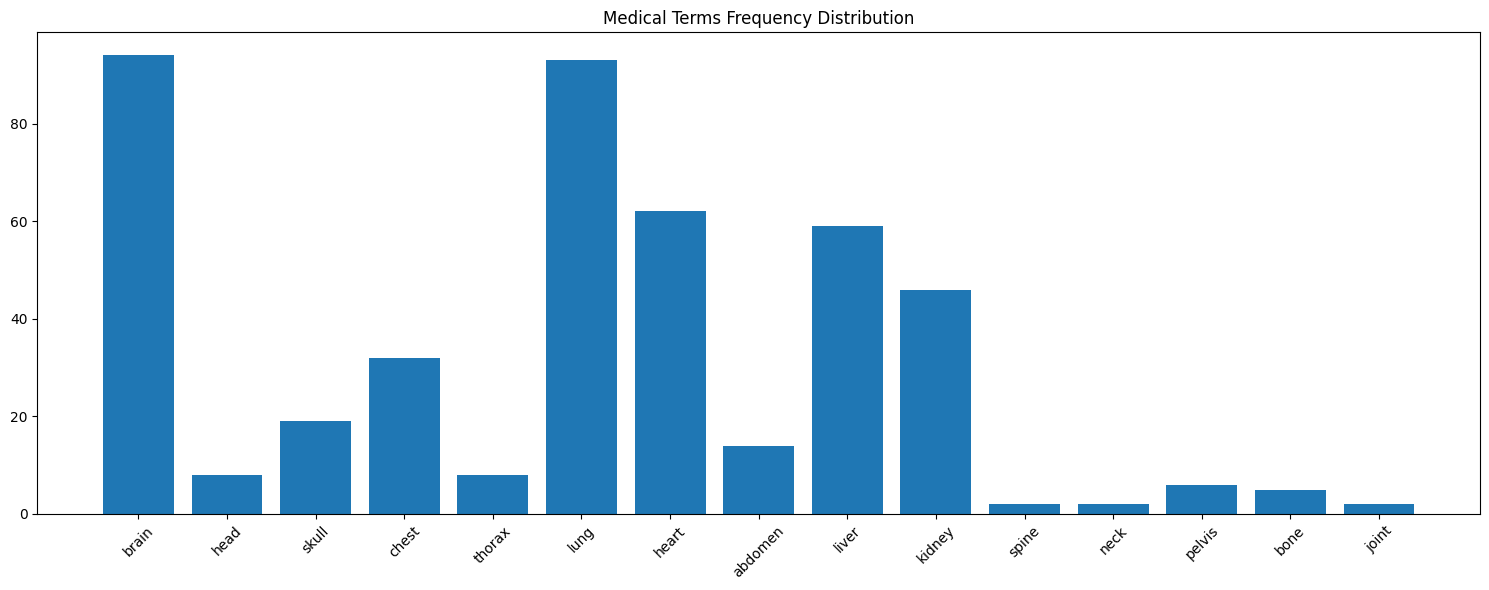


=== Analyzing Modality Distribution ===


Analyzing modalities: 100%|██████████| 2244/2244 [00:00<00:00, 20447.35it/s]


Modality mentions in dataset:
MRI: 75
CT: 49
XRAY: 78


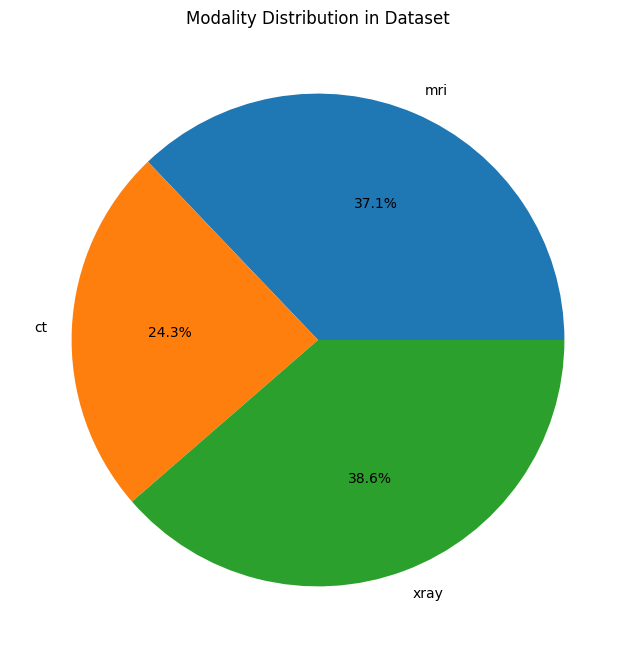


=== Question Pattern Analysis ===
what_is: 184 (8.20%)
is_there: 356 (15.86%)
where_is: 106 (4.72%)
are_there: 57 (2.54%)
can_you_see: 9 (0.40%)
describe: 9 (0.40%)
identify: 0 (0.00%)

=== Detailed Dataset Analysis ===

Text Length Statistics:

Questions:
count    2244.000000
mean       38.622103
std        14.045934
min        13.000000
25%        28.000000
50%        36.000000
75%        46.000000
max       134.000000
Name: question, dtype: float64

Answers:
count    2244.000000
mean        8.331551
std        10.983255
min         1.000000
25%         2.000000
50%         3.000000
75%        11.000000
max       118.000000
Name: answer, dtype: float64


NameError: name 'modality_patterns' is not defined

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_anatomy_patterns(df):
    """分析数据集中出现的解剖相关词汇"""
    from collections import Counter
    import re

    print("\n=== Analyzing Anatomy Patterns in Dataset ===")

    # 基础医学词汇列表（初始列表，将根据数据集扩充）
    medical_terms = [
        'brain', 'head', 'skull', 'chest', 'thorax', 'lung',
        'heart', 'abdomen', 'liver', 'kidney', 'spine', 'neck',
        'pelvis', 'bone', 'joint', 'arm', 'leg'
    ]

    # 存储结果
    question_terms = []
    answer_terms = []

    # 对每个样本进行分析
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing text"):
        # 处理问题
        question = row['question'].lower()
        # 分词并提取可能的医学术语
        words = re.findall(r'\b\w+\b', question)
        question_terms.extend(words)

        # 处理答案
        answer = row['answer'].lower()
        words = re.findall(r'\b\w+\b', answer)
        answer_terms.extend(words)

    # 统计词频
    question_counter = Counter(question_terms)
    answer_counter = Counter(answer_terms)

    print("\n=== Word Frequency Analysis ===")
    print("\nTop 30 terms in questions:")
    for term, count in question_counter.most_common(30):
        print(f"{term}: {count}")

    print("\nTop 30 terms in answers:")
    for term, count in answer_counter.most_common(30):
        print(f"{term}: {count}")

    # 分析医学术语
    print("\n=== Medical Term Analysis ===")
    print("\nMedical terms found in questions:")
    for term in medical_terms:
        if term in question_counter:
            print(f"{term}: {question_counter[term]}")

    print("\nMedical terms found in answers:")
    for term in medical_terms:
        if term in answer_counter:
            print(f"{term}: {answer_counter[term]}")

    # 分析包含解剖术语的完整句子示例
    print("\n=== Sample Sentences with Anatomical Terms ===")
    sample_count = 0
    for _, row in df.iterrows():
        question = row['question'].lower()
        answer = row['answer'].lower()

        # 检查是否包含医学术语
        if any(term in question for term in medical_terms):
            print(f"\nQuestion: {row['question']}")
            sample_count += 1
        if any(term in answer for term in medical_terms):
            print(f"Answer: {row['answer']}")
            sample_count += 1

        if sample_count >= 10:  # 显示10个样本
            break

    # 根据问题和答案总结可能的解剖区域组合
    print("\n=== Potential Anatomy Region Combinations ===")
    region_combinations = []
    for _, row in df.iterrows():
        question = row['question'].lower()
        answer = row['answer'].lower()
        combined_text = question + " " + answer

        # 收集在同一样本中出现的解剖术语
        terms_found = [term for term in medical_terms if term in combined_text]
        if terms_found:
            region_combinations.append(tuple(sorted(terms_found)))

    combination_counter = Counter(region_combinations)
    print("\nCommon anatomy term co-occurrences:")
    for combo, count in combination_counter.most_common(10):
        print(f"{combo}: {count}")

    # 绘制医学术语频率分布图
    plt.figure(figsize=(15, 6))
    terms = []
    counts = []
    for term in medical_terms:
        if term in question_counter or term in answer_counter:
            terms.append(term)
            counts.append(question_counter[term] + answer_counter[term])

    plt.bar(terms, counts)
    plt.title('Medical Terms Frequency Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'question_terms': question_counter,
        'answer_terms': answer_counter,
        'common_combinations': combination_counter
    }

def analyze_modality_distribution(df):
    """分析模态相关的词汇分布"""
    print("\n=== Analyzing Modality Distribution ===")

    modality_patterns = {
        'mri': r'\b(mri|magnetic resonance( imaging)?|mr imaging|nmr|flair|t2|weighted)\b',
        'ct': r'\b(ct scan|ct|computed tomography|cat scan)\b',
        'xray': r'\b(x-ray|xray|radiograph|radiography|chest x|cxr|pa)\b'
    }

    anatomy_patterns = {
        'neuro': r'\b(brain|brainstem|cerebellum|skull|head|cerebral|intracranial|midbrain)\b',
        'chest': r'\b(lung|chest|thorax|heart|pleural|pulmonary|cardiac)\b',
        'abdomen': r'\b(liver|kidney|abdomen|pelvis|abdominal)\b'
    }

    # 新增图像特征模式
    image_patterns = {
        'contrast': r'\b(contrast|enhanced|enhancement)\b',
        'sequence': r'\b(flair|t2|weighted|axial|pa)\b',
        'orientation': r'\b(lateral|bilateral|left|right)\b'
    }

    modality_counts = {k: 0 for k in modality_patterns.keys()}

    # 分析问题和答案中的模态信息
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing modalities"):
        text = (row['question'] + ' ' + row['answer']).lower()
        for modality, pattern in modality_patterns.items():
            if re.search(pattern, text):
                modality_counts[modality] += 1

    print("\nModality mentions in dataset:")
    for modality, count in modality_counts.items():
        print(f"{modality.upper()}: {count}")

    # 绘制模态分布饼图
    plt.figure(figsize=(10, 8))
    plt.pie(modality_counts.values(), labels=modality_counts.keys(), autopct='%1.1f%%')
    plt.title('Modality Distribution in Dataset')
    plt.show()

def analyze_question_patterns(df):
    """分析问题中的常见句式模式"""
    question_patterns = {
        'what_is': r'^what is',
        'is_there': r'^is there',
        'where_is': r'^where is',
        'are_there': r'^are there',
        'can_you_see': r'^can you see',
        'describe': r'^describe',
        'identify': r'^identify'
    }

    pattern_counts = {k: 0 for k in question_patterns.keys()}

    for _, row in df.iterrows():
        question = row['question'].lower()
        for pattern_name, pattern in question_patterns.items():
            if re.search(pattern, question):
                pattern_counts[pattern_name] += 1

    print("\n=== Question Pattern Analysis ===")
    for pattern, count in pattern_counts.items():
        print(f"{pattern}: {count} ({count/len(df)*100:.2f}%)")

    return pattern_counts

def detailed_analysis(df):
    """详细的数据集统计分析"""
    print("\n=== Detailed Dataset Analysis ===")

    # 1. 问答长度分析
    question_lengths = df['question'].str.len()
    answer_lengths = df['answer'].str.len()

    print("\nText Length Statistics:")
    print("\nQuestions:")
    print(question_lengths.describe())
    print("\nAnswers:")
    print(answer_lengths.describe())

    # 2. 模态-解剖区域关联分析
    modality_anatomy_pairs = []
    for _, row in df.iterrows():
        text = row['question'].lower() + ' ' + row['answer'].lower()

        # 检测模态
        modality = None
        for mod, pattern in modality_patterns.items():
            if re.search(pattern, text):
                modality = mod
                break

        # 检测解剖区域
        anatomy = None
        for anat, pattern in anatomy_patterns.items():
            if re.search(pattern, text):
                anatomy = anat
                break

        if modality and anatomy:
            modality_anatomy_pairs.append((modality, anatomy))

    pair_counter = Counter(modality_anatomy_pairs)
    print("\nModality-Anatomy Pairs Distribution:")
    for pair, count in pair_counter.most_common():
        print(f"{pair}: {count}")

    # 3. 可视化
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(question_lengths, bins=30)
    plt.title('Question Length Distribution')

    plt.subplot(122)
    plt.hist(answer_lengths, bins=30)
    plt.title('Answer Length Distribution')

    plt.tight_layout()
    plt.show()

    return {
        'question_lengths': question_lengths,
        'answer_lengths': answer_lengths,
        'modality_anatomy_pairs': pair_counter
    }

def main():
    # 加载数据
    print("Loading RAD dataset...")
    train_path = '/content/drive/MyDrive/PhD/Research1/RADdataset/train-00000-of-00001-eb8844602202be60.parquet'
    test_path = '/content/drive/MyDrive/PhD/Research1/RADdataset/test-00000-of-00001-e5bc3d208bb4deeb.parquet'

    print("Loading RAD dataset...")
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # 基础分析
    analyze_anatomy_patterns(combined_df)
    analyze_modality_distribution(combined_df)

    # 新增分析
    question_patterns = analyze_question_patterns(combined_df)
    detailed_stats = detailed_analysis(combined_df)

    # 保存分析结果
    results = {
        'question_patterns': question_patterns,
        'detailed_stats': detailed_stats
    }

    return results

if __name__ == "__main__":
    main()